In [3]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [4]:

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [5]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42, create_dirs=True) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);



In [6]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]

In [7]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y)

# Normalize data
X_train = X_train/255.
X_test = X_test/255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y_train)
old_y_train = Y_train

In [8]:
# X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train,5000, disable_tqdm=True)

In [9]:
X_train.shape,X_test.shape,X_val.shape

((2834, 96, 96, 3), (354, 96, 96, 3), (354, 96, 96, 3))

In [10]:
Y_train.shape,Y_test.shape,Y_val.shape

((2834, 8), (354, 8), (354, 8))

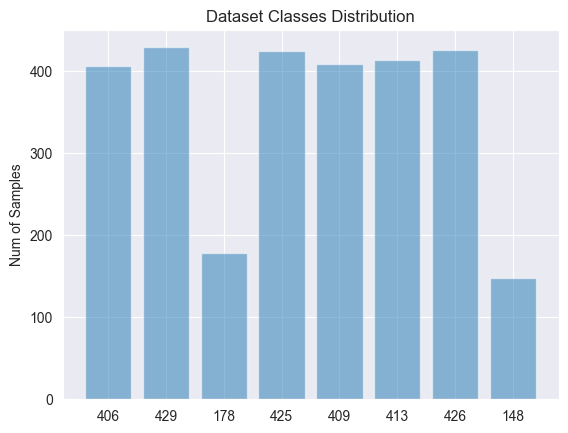

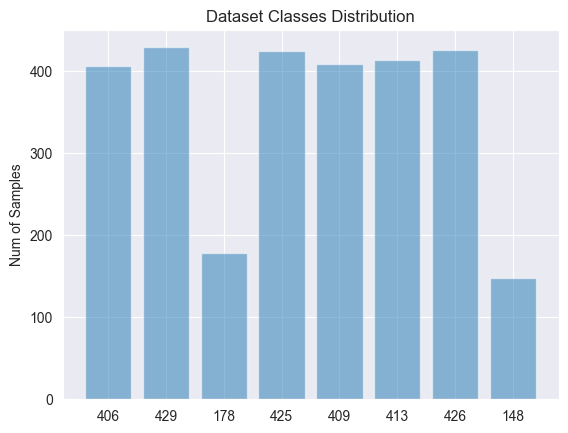

In [11]:
dataset_helper.plot_samples_distribution(old_y_train)
dataset_helper.plot_samples_distribution(Y_train)

In [12]:
input_shape = X_train.shape[1:] # 96*96*3
batch_size = 128
epochs = 50

In [13]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    depth = 4
    start_n_f = 32
    last_layer = input_layer
    for i in range(depth):
        kernel_size = (5,5) if i == 0 else (3,3)
        conv = tfkl.Conv2D(
            filters=start_n_f,
            kernel_size=kernel_size,
            strides = (1, 1),
            padding = 'same',
            activation = None,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)
        batch = BatchNormalization()(conv)
        merged = tfkl.Add()([last_layer, batch])
        activation = tfkl.Activation('relu')(merged)
        pool = tfkl.MaxPooling2D(pool_size = (2, 2))(activation)
        last_layer = pool
        start_n_f *= 2

    flattening_layer = tfkl.Flatten(name='Flatten')(last_layer)
    classifier_layer = tfkl.Dense(
        units=800,
        name='Classifier',
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [14]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

Metal device set to: Apple M1 Pro


2022-11-14 13:13:55.656562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 13:13:55.656907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ValueError: Inputs have incompatible shapes. Received shapes (96, 96, 3) and (96, 96, 32)

In [18]:
X_val.shape,Y_val.shape

((354, 96, 96, 3), (354, 8))

In [19]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=25)

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/50


2022-11-13 23:05:24.270448: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-13 23:05:24.680649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - ETA: 0s - loss: 5.7724 - accuracy: 0.1792

2022-11-13 23:05:32.044355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 8s 129ms/step - loss: 5.7724 - accuracy: 0.1792 - val_loss: 3.0697 - val_accuracy: 0.1525
Epoch 2/50
59/59 [==============================] - 6s 99ms/step - loss: 1.9409 - accuracy: 0.2231 - val_loss: 2.3162 - val_accuracy: 0.1525
Epoch 3/50
59/59 [==============================] - 6s 99ms/step - loss: 1.8987 - accuracy: 0.2268 - val_loss: 2.3615 - val_accuracy: 0.1582
Epoch 4/50
59/59 [==============================] - 6s 99ms/step - loss: 1.8537 - accuracy: 0.2540 - val_loss: 2.2641 - val_accuracy: 0.1469
Epoch 5/50
59/59 [==============================] - 6s 99ms/step - loss: 1.8276 - accuracy: 0.2603 - val_loss: 2.2019 - val_accuracy: 0.1977
Epoch 6/50
59/59 [==============================] - 6s 99ms/step - loss: 1.7778 - accuracy: 0.2891 - val_loss: 2.1167 - val_accuracy: 0.2175
Epoch 7/50
59/59 [==============================] - 6s 102ms/step - loss: 1.7175 - accuracy: 0.3220 - val_loss: 4.4010 - val_accuracy: 0.1158
Epoch 8/50
59/59 [====

In [20]:
model_helper.save_model(model,'model2')

INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model2/assets


In [6]:

model = model_helper.load_model('model2')
model.summary()

Metal device set to: Apple M1 Pro


2022-11-13 23:21:24.594849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-13 23:21:24.594963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496 

 6/12 [==============>...............] - ETA: 0s

2022-11-13 23:21:28.142973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-13 23:21:28.198738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step


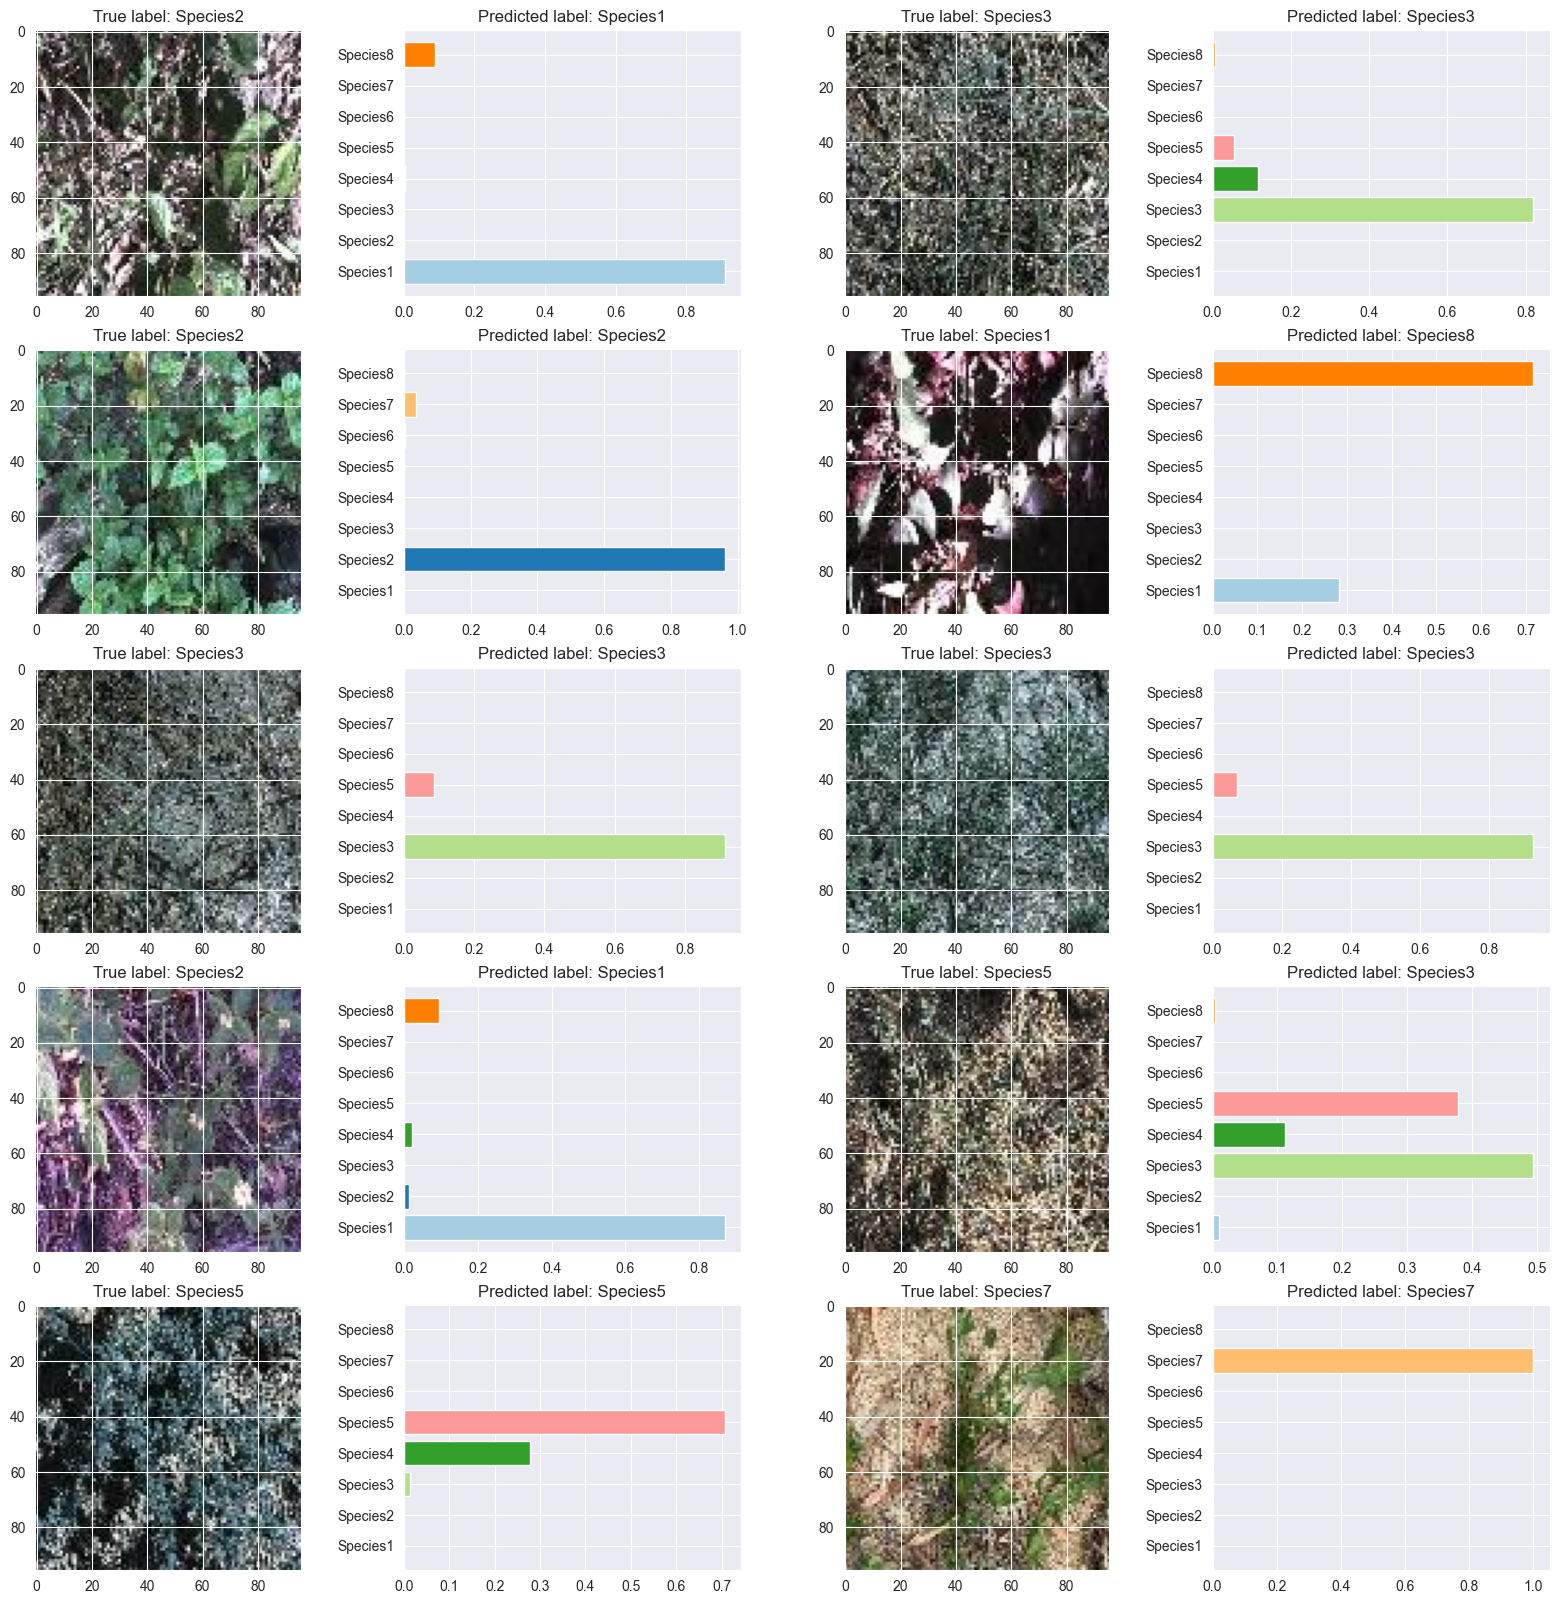

In [7]:
model_helper.show_predictions(X_test,Y_test,16)

In [8]:
#PLOT THE TRAINING PHASE VS VALIDATION BOTH IN LOSS AND ACCURACY
model_helper.plot_phase_train_vs_validation(history)

NameError: name 'history' is not defined

12/12 [==============================] - 0s 13ms/step
Accuracy: 0.6667
Precision: 0.6419
Recall: 0.624
F1: 0.6224


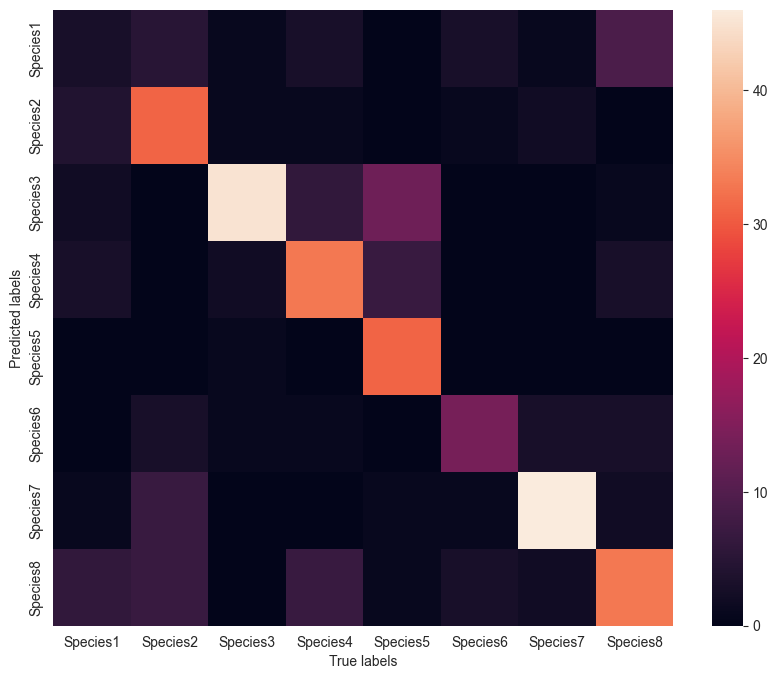

In [9]:
#PLOT CONFUSION MATRIX OF OUR MODEL
#It is good if diagonal has high values and other part of matrix is dark
#Bad if a row has ALL dark cells
#EG species 1 and species 6 has less images in the datase... and here the confusion matrix has all black on them..
model_helper.show_confusion_matrix(X_test,Y_test)

In [70]:
#Submission Model for the challenge -> Path is the folder on the server where our script is
class SubmissionModel:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model1'))

    def predict(self, X):

        # Insert your preprocessing here

        out = self.model.predict(X)
        out = np.argmax(out, axis=-1)
        return out

In [ ]:
testing_index = 44
image_to_test = X_test[[testing_index],:]
#image_to_test = X_test[10,None,:]
#image_to_test = np.expand_dims(image_to_test,0)
image_to_test.shape


In [ ]:
print("Real Class: ")
print(labels[np.argmax(Y_test[testing_index])])
tester = SubmissionModel("../../local_saved_models/")
res = tester.predict(image_to_test)
labels[res[0]]

In [ ]:
#Predict all test at oance
predicted_vector = model.predict(X_test)
predicted_vector.shape